# Mission - Classifiez automatiquement des informations

Vous êtes mandaté en tant que Consultant Data Scientist par le département RH de votre client. Il s’agit de l'ESN TechNova Partners, spécialisée dans le conseil en transformation digitale et la vente d’applications en SaaS.
 
Ils font face à un turnover plus élevé que d'habitude et ils souhaitent identifier les causes racines potentielles derrière ces démissions.

### Importation des librairies

In [1]:
# Librairies "classiques"
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.io as pio
from IPython.display import Image, display

# Librairies scikit-learn
from sklearn.model_selection import (
    train_test_split,
    GridSearchCV, 
    cross_validate,
)
# Preprocess et modèles
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, cross_validate
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import average_precision_score, precision_recall_curve, roc_auc_score, auc, f1_score, balanced_accuracy_score

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier, Pool

# Fonctions python créées
from utils import prepare_xy
from utils import scaler_ou_non

### On reprend les éléments du notebook de l'étape 2

In [2]:
donnees_modelisation = pd.read_csv("../Data/Processed/Projet_4_etape2_clean.csv")

# Partie 5 - Optimisez et interprétez le comportement du modèle

### Recommandation 1 - Reprenez les mêmes principes que le projet 3 (si vous suivez ce parcours dans sa totalité) pour le fine-tuning.
* Afin de trouver les meilleurs hyperparamètres de notre modèle sélectionné, CatBoost, nous utilisons un GridSearchCV pour les rechercher.

#### Récupération de notre séparation X et y et de nos features

In [3]:
X, y = prepare_xy(donnees_modelisation)
features_a_scaler, features_encodees = scaler_ou_non()

#### Recherche des hyperparamètres

In [4]:
# Séparation de X et y
X, y
# Test en jeu d'apprentissage et de test
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.20, random_state=42, stratify = y)
# Transformation des colonnes et enregistrement dans un pipeline
preprocessor = ColumnTransformer(
    transformers = [
        ('num', StandardScaler(),features_a_scaler),
        ('cat','passthrough',features_encodees)
    ])
pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model',CatBoostClassifier(random_state = 42, verbose=0))
])
# Enregistrement des paramètres
param_grid = {
    'model__iterations' : [100, 200, 300, 500],
    'model__depth' : [2, 3, 4],
    'model__learning_rate' : [0.01, 0.02, 0.03, 0.04, 0.05],
    'model__class_weights' : [[1, 3], [1, 5], [1, 7]],
}
# Mise en place du GridSearchCV
cv = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
grid_search = GridSearchCV(
    estimator = pipeline,
    param_grid = param_grid,
    cv = cv,
    n_jobs = -1,
    scoring='recall', #choix du recall par logique avec l'étape précédente
    verbose = 0
)
# Entraînement du modèle
grid_search.fit(X_train, y_train)
# J'enregistre quel est le meilleur modèle, je réalise la prédiction et j'évalue
best_model = grid_search.best_estimator_
print("Meilleurs paramètres :", grid_search.best_params_)
print("Meilleur recall :", grid_search.best_score_)

Meilleurs paramètres : {'model__class_weights': [1, 7], 'model__depth': 2, 'model__iterations': 100, 'model__learning_rate': 0.01}
Meilleur recall : 0.8207671957671958


#### L'utilisation de GridSearchCV nous donne des hyperparamètres qui améliorent le racall de notre modèle par rapport à l'étape 4.

Les meilleurs paramètres sont :
* 'model__class_weights': [1, 5]
* 'model__depth': 3
* 'model__iterations': 500
* 'model__l2_leaf_reg': 3
* 'model__learning_rate': 0.01

### On peut désormais lancer une validation croisée avec nos nouveaux hyperparamètres optimisés 

In [5]:
# Séparation X/y
X, y = prepare_xy(donnees_modelisation)

# Récupération des features à scaler/passthrough 
features_a_scaler, features_encodees = scaler_ou_non()

# Split Train/Test avec stratification
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify = y)
    
# Pipeline : prétraitements + modèle
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), features_a_scaler),
        ('cat', 'passthrough', features_encodees)])

pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('model', CatBoostClassifier(
        iterations=100, #nombre d’arbres boostés
        depth=2, # profondeur des arbres
        learning_rate=0.01, # vitesse d’apprentissage
        class_weights=[1, 7], # pondération des classes
        random_state=42,
        verbose=0
    ))])

# Validation croisée sur l'entraînement (stockage moyennes/écarts-types)
scoring = ['precision', 'recall', 'f1', 'average_precision', 'balanced_accuracy']  # average_precision = PR AUC
cv = StratifiedKFold(n_splits=3)
cv_results = cross_validate(
    pipeline,
    X_train, y_train,
    cv=cv,
    scoring=scoring,
    return_train_score=True,
    n_jobs=-1)

print("=== Résultats CV (train vs val) ===")
for metric in scoring:
    tr = cv_results[f"train_{metric}"]
    te = cv_results[f"test_{metric}"]
    print(f"{metric:18s}: train {tr.mean():.3f} ± {tr.std():.3f} vs val {te.mean():.3f} ± {te.std():.3f}")

=== Résultats CV (train vs val) ===
precision         : train 0.262 ± 0.013 vs val 0.235 ± 0.009
recall            : train 0.871 ± 0.032 vs val 0.795 ± 0.021
f1                : train 0.402 ± 0.017 vs val 0.362 ± 0.009
average_precision : train 0.581 ± 0.027 vs val 0.496 ± 0.050
balanced_accuracy : train 0.698 ± 0.020 vs val 0.647 ± 0.008


Sur le jeu d'entraînement notre modèle est amélioré sur le recall par rapport au jeu de test final :
* 0.795 vs 0.660 le seuil à 0.5
* 0.795 vs 0.766 le seuil optimal à 0.44

#### Dans la même logique que l'étape 4 nous allons recalculer le seuil optimal pour qu'il soit adapté à nos nouveaux paramètres.

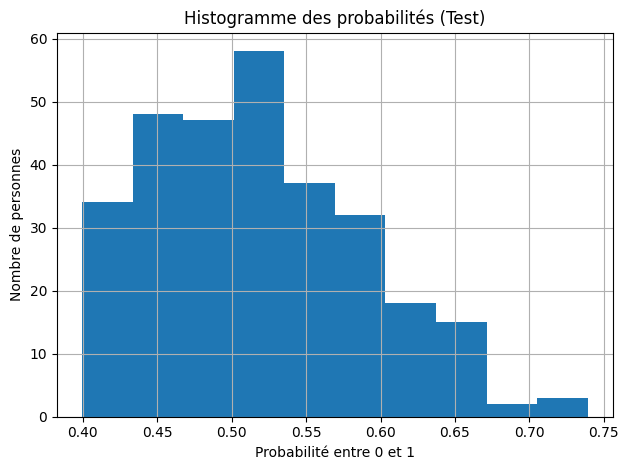

In [7]:
# Split interne Train/Validation pour choisir le seuil et entraînement de ce dernier
X_tr, X_val, y_tr, y_val = train_test_split(
X_train, y_train, test_size=0.25, random_state=42, stratify=y_train)

pipeline.fit(X_tr, y_tr)
proba_val = pipeline.predict_proba(X_val)[:,1] # Cette ligne récupère pour chaque individu du jeu X_val, la probabilité d’appartenir à la classe 1
precision_val, recall_val, thresholds_val = precision_recall_curve(y_val, proba_val)

# Création du seuil fbeta
beta = 2 # afin de mettre des poids supplémentaires sur le recall
f_beta = (1 + beta**2) * (precision_val * recall_val) / (beta**2 * precision_val + recall_val)
idx = int(np.nanargmax(f_beta))
best_thr = float(thresholds_val[idx])

pipeline.fit(X_train, y_train)
# Évaluation TEST (sans rechoisir le seuil, soit 0,5)
y_pred_train = pipeline.predict(X_train)
y_pred_test = pipeline.predict(X_test)
proba_test = pipeline.predict_proba(X_test)[:, 1]

# Histogramme des probabilités (Test)
plt.hist(proba_test)
plt.title("Histogramme des probabilités (Test)")
plt.xlabel("Probabilité entre 0 et 1")
plt.ylabel("Nombre de personnes")
plt.grid()
plt.tight_layout()
plt.show()

Par rapport au précédent histogramme, on peut observer que la concentration qui était entre 0.2 et 0.5 se situe un peu plus haut désormais, le modèle est toujours peu confiant.

#### Courbe de la précision-rappel et détermination du seuil fbeta

PR AUC (Average Precision) — TEST : 0.510


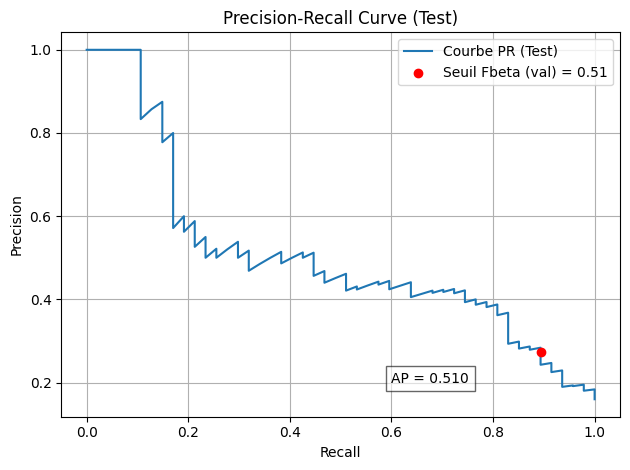

In [8]:
ap_test = average_precision_score(y_test, proba_test)   # PR AUC (Average Precision) — Test
print(f"PR AUC (Average Precision) — TEST : {ap_test:.3f}")
# Courbe PR (Test) pour visualiser + point au seuil optimal
precision_test, recall_test, thresholds_test = precision_recall_curve(y_test, proba_test)
# Point obtenu par application du seuil sur test
y_pred_custom = (proba_test >= best_thr).astype(int)
tp = ((y_test==1) & (y_pred_custom==1)).sum()
fp = ((y_test==0) & (y_pred_custom==1)).sum()
fn = ((y_test==1) & (y_pred_custom==0)).sum()
prec_pt = tp / (tp + fp)
rec_pt  = tp / (tp + fn)
plt.plot(recall_test, precision_test, label="Courbe PR (Test)")
plt.scatter(rec_pt, prec_pt, color="red", zorder=5, label=f"Seuil Fbeta (val) = {best_thr:.2f}")
plt.text(0.6, 0.2, f"AP = {ap_test:.3f}", fontsize=10, bbox=dict(facecolor='white', alpha=0.6))
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (Test)")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

* Le seuil est désormais à 0.51, non loin du seuil standard.

In [9]:
print("=== balanced accuracy score - TEST (0.5) ===")
print(round(balanced_accuracy_score(y_test, y_pred_test), 3))
print(f"=== balanced accuracy score - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(round(balanced_accuracy_score(y_test, y_pred_custom), 3))

=== balanced accuracy score - TEST (0.5) ===
0.694
=== balanced accuracy score - TEST (seuil F2.0 VALIDATION) ===
0.72


* Le score de la balanced_accuracy est légèrement meilleur avec le seuil optimal, on obtient donc un meilleur équilibre entre la précision-rappel.

#### Classification report

In [10]:
print("=== Classification Report - TRAIN ===")
print(classification_report(y_train, y_pred_train, digits=3))
print("=== Classification Report - TEST (0.5) ===")
print(classification_report(y_test, y_pred_test, digits=3))
print(f"=== Classification Report — TEST (seuil F{beta:.1f} VALIDATION) ===")
print(classification_report(y_test, y_pred_custom, digits=3))

=== Classification Report - TRAIN ===
              precision    recall  f1-score   support

           0      0.952     0.521     0.674       986
           1      0.258     0.863     0.397       190

    accuracy                          0.577      1176
   macro avg      0.605     0.692     0.535      1176
weighted avg      0.840     0.577     0.629      1176

=== Classification Report - TEST (0.5) ===
              precision    recall  f1-score   support

           0      0.961     0.494     0.652       247
           1      0.251     0.894     0.393        47

    accuracy                          0.558       294
   macro avg      0.606     0.694     0.522       294
weighted avg      0.847     0.558     0.611       294

=== Classification Report — TEST (seuil F2.0 VALIDATION) ===
              precision    recall  f1-score   support

           0      0.964     0.547     0.698       247
           1      0.273     0.894     0.418        47

    accuracy                          0.

Entre le seuil standard et le seuil optimal, pas d'amélioration, ce qui est logique car le seuil est très semblable. 
* On a un très bon recall de l'ordre de 90% pour une précision plus faible de 27%. Nous gardons la logique du contexte métier, nous voulons rater le moins de départs possible au prix de considérer plus de faux positifs.

In [11]:
cm_test  = confusion_matrix(y_test, y_pred_test)
print("=== Matrice de confusion - TEST (0.5) ===")
print(cm_test)

cm_test_optimal  = confusion_matrix(y_test, y_pred_custom)
print(f"=== Matrice de confusion - TEST (seuil F{beta:.1f} VALIDATION) ===")
print(cm_test_optimal)

=== Matrice de confusion - TEST (0.5) ===
[[122 125]
 [  5  42]]
=== Matrice de confusion - TEST (seuil F2.0 VALIDATION) ===
[[135 112]
 [  5  42]]
